<a href="https://colab.research.google.com/github/SujayVivek/SPML-LAB-4thYR/blob/main/SPLabAssignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary libraries


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter, maximum_filter
from skimage.feature import canny

In [2]:
file_path = r"imageex.jpg"
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

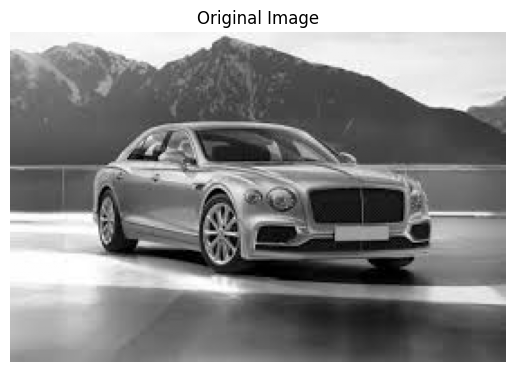

In [3]:
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

Adding Salt and Pepper Noise (Using Library)

In [4]:
salt_prob = 0.02
pepper_prob = 0.05
noise_img = random_noise(img, mode = 's&p', amount = salt_prob + pepper_prob)

noise_img = (255*noise_img).astype(np.uint8)


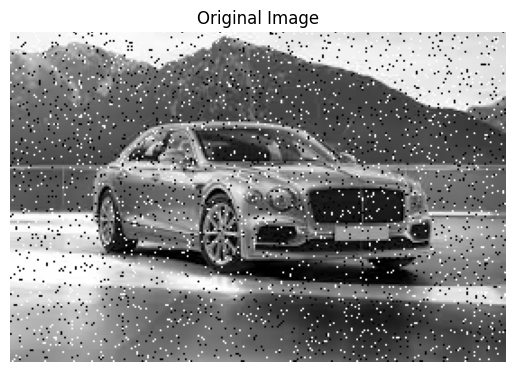

In [5]:
plt.imshow(noise_img, cmap = 'gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

Adding Salt and Pepper (Without Library)

In [14]:
import numpy as np

def add_sp_noise_2d_u8(img, salt_prob=0.02, pepper_prob=0.05, seed=None):
    assert img.ndim == 2, "Expected a 2D grayscale image."
    assert img.dtype == np.uint8, "This minimal version expects uint8."
    assert 0 <= salt_prob <= 1 and 0 <= pepper_prob <= 1 and (salt_prob + pepper_prob) <= 1, \
        "Probabilities must be in [0,1] and sum ≤ 1."

    rng = np.random.default_rng(seed)
    noisy = img.copy()

    r = rng.random(img.shape)          # random numbers in [0,1) per pixel
    noisy[r < pepper_prob] = 0         # pepper = black
    noisy[r > 1.0 - salt_prob] = 255   # salt = white
    return noisy


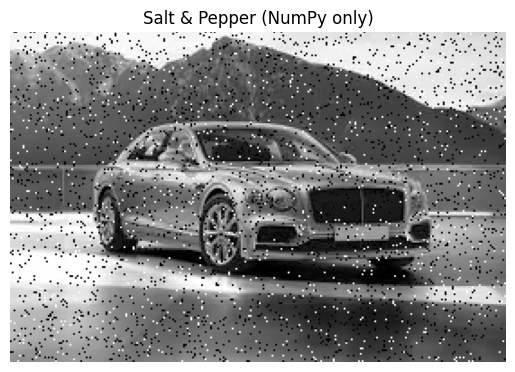

In [10]:
noise_img_np = add_sp_noise_2d_u8(img, salt_prob=0.02, pepper_prob=0.05, seed=0)

plt.imshow(noise_img_np, cmap='gray')
plt.title('Salt & Pepper (NumPy only)')
plt.axis('off')
plt.show()

Applying Mean, Median and Gauss Filter: Using Library

noise_img: shape=(183, 275), dtype=uint8, ndim=2
mean_cv: shape=(183, 275), dtype=uint8, ndim=2
gauss_cv: shape=(183, 275), dtype=uint8, ndim=2
median_cv: shape=(183, 275), dtype=uint8, ndim=2


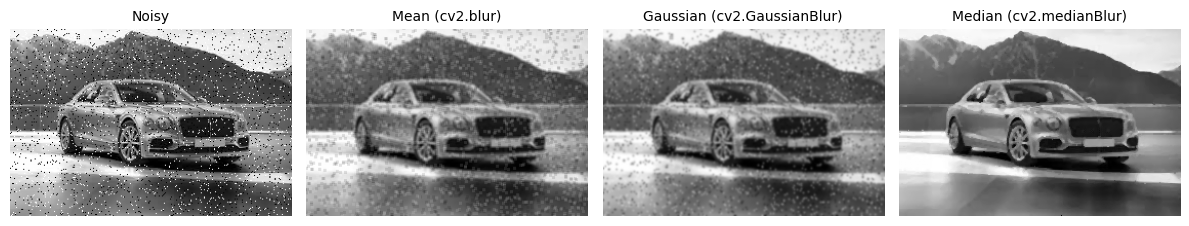

In [17]:
k_mean   = 3
k_gauss  = 5
sigma    = 1.0
k_median = 3

mean_cv   = cv2.blur(noise_img, (k_mean, k_mean))
gauss_cv  = cv2.GaussianBlur(noise_img, (k_gauss, k_gauss), sigmaX=sigma, borderType=cv2.BORDER_REFLECT)
median_cv = cv2.medianBlur(noise_img, k_median)

for name, arr in [("noise_img", noise_img), ("mean_cv", mean_cv), ("gauss_cv", gauss_cv), ("median_cv", median_cv)]:
    print(f"{name}: shape={arr.shape}, dtype={arr.dtype}, ndim={arr.ndim}")
    assert arr.ndim == 2, f"{name} is not 2D; got {arr.shape}"

titles = ['Noisy', 'Mean (cv2.blur)', 'Gaussian (cv2.GaussianBlur)', 'Median (cv2.medianBlur)']
imgs   = [noise_img, mean_cv, gauss_cv, median_cv]

plt.figure(figsize=(12,4))
for i, (t, im) in enumerate(zip(titles, imgs), 1):
    plt.subplot(1,4,i)
    plt.imshow(im, cmap='gray')
    plt.title(t, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

Implementation from Scratch (Without Library)

In [26]:
def mean_filter_2d(img, k = 3):
  assert img.ndim == 2, "Expected 2D grayscale image"
  assert k%2 == 1 and k>=3, "Expected odd sized kernel and must be of size >=3"

  pad = k//2
  padded = np.pad(img, pad, mode = 'reflect')

  out = np.empty_like(img, dtype = np.float32)
  area = k*k

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      window = padded[i:i+k, j:j+k]
      out[i, j] = window.sum()/area

  if np.issubdtype(img.dtype, np.integer):
        out = np.clip(out, 0, np.iinfo(img.dtype).max)
  else:
        out = np.clip(out, 0.0, 1.0)
  return out.round().astype(img.dtype)

In [23]:
def gaussian_kernel(k, sigma = None):
  assert k%2==1 and k>=3, "Expected Odd Kernel Size and size>=3"
  if sigma is None:
    sigma = 0.3*((k-1)*0.5 - 1) + 0.8

  ax = np.arange(-(k//2), k//2 + 1)
  xx, yy = np.meshgrid(ax, ax)
  kernel = np.exp(-(xx**2 + xx*2)/(2 * sigma**2))
  kernel/=kernel.sum()
  return kernel.astype(np.float32)

def gaussian_filter_2d(img, k = 5, sigma = 1.0):
  assert img.ndim == 2, "expected 2d grayscale image"
  kernel = gaussian_kernel(k, sigma)
  pad = k//2;
  padded = np.pad(img, pad, mode = 'reflect')
  out = np.empty_like(img, dtype= np.float32)

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      window = padded[i:i+k, j:j+k]
      out[i, j] = np.sum(window*kernel)

  if np.issubdtype(img.dtype, np.integer):
      out = np.clip(out, 0, np.iinfo(img.dtype).max)
  else:
      out = np.clip(out, 0.0, 1.0)
  return out.round().astype(img.dtype)


In [24]:
def median_filter_2d(img, k = 3):
  assert img.ndim == 2, "Expected 2D grayscale image"
  assert k%2 == 1 and k>=3, "Expected odd sized kernel and must be of size >=3"
  pad = k//2
  padded = np.pad(img, pad, mode = 'reflect')
  out = np.empty_like(img, dtype = np.float32)

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      window = padded[i:i+k, j:j+k]
      out[i, j] = np.median(window)

  if np.issubdtype(img.dtype, np.integer):
      out = np.clip(out, 0, np.iinfo(img.dtype).max)
  else:
      out = np.clip(out, 0.0, 1.0)
  return out.round().astype(img.dtype)


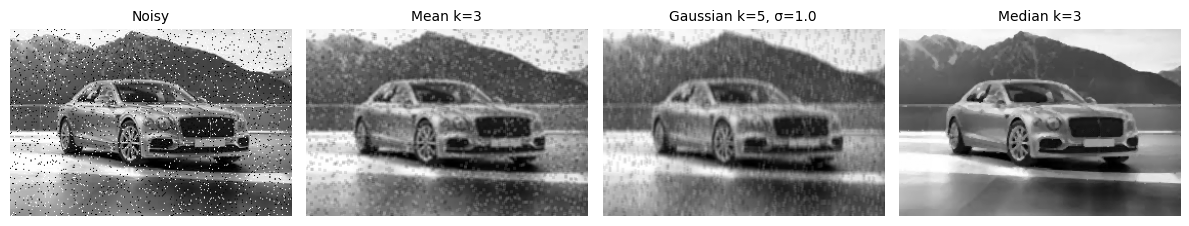

In [27]:
k_mean, k_gauss, k_median = 3, 5, 3
sigma = 1.0

mean_np   = mean_filter_2d(noise_img, k=k_mean)
gauss_np  = gaussian_filter_2d(noise_img, k=k_gauss, sigma=sigma)
median_np = median_filter_2d(noise_img, k=k_median)

titles = ['Noisy', f'Mean k={k_mean}', f'Gaussian k={k_gauss}, σ={sigma}', f'Median k={k_median}']
imgs   = [noise_img, mean_np, gauss_np, median_np]

plt.figure(figsize=(12,4))
for i, (t, im) in enumerate(zip(titles, imgs), 1):
    plt.subplot(1,4,i)
    plt.imshow(im, cmap='gray')
    plt.title(t, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


Applying high pass filters (Using OpenCV)

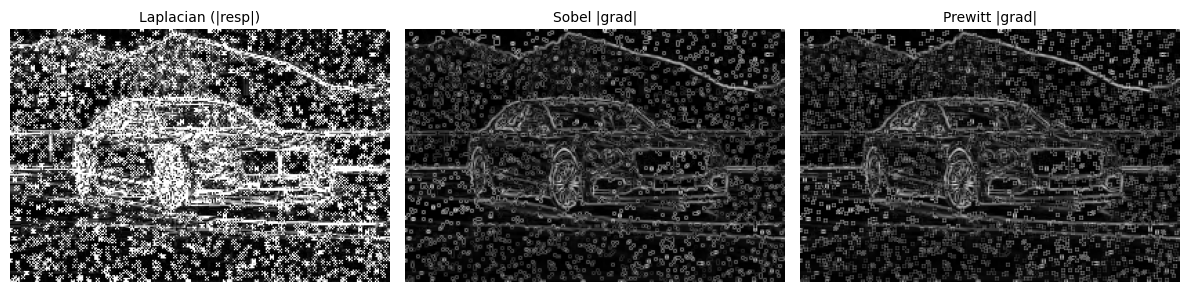

In [29]:
# Use your 2D grayscale image here
src = noise_img  # or: src = img
assert src.ndim == 2 and src.dtype == np.uint8, f"Expected 2D uint8, got {src.shape}, {src.dtype}"

# --- Laplacian ---
lap = cv2.Laplacian(src, ddepth=cv2.CV_32F, ksize=3, borderType=cv2.BORDER_REFLECT)
lap_show = cv2.convertScaleAbs(lap)  # abs + scale for display

# --- Sobel (magnitude) ---
sx = cv2.Sobel(src, cv2.CV_32F, 1, 0, ksize=3, borderType=cv2.BORDER_REFLECT)
sy = cv2.Sobel(src, cv2.CV_32F, 0, 1, ksize=3, borderType=cv2.BORDER_REFLECT)
sobel_mag = cv2.magnitude(sx, sy)
sobel_show = cv2.normalize(sobel_mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# --- Prewitt (magnitude) ---
prewitt_x = np.array([[-1, 0, 1],
                      [-1, 0, 1],
                      [-1, 0, 1]], dtype=np.float32)
prewitt_y = np.array([[ 1,  1,  1],
                      [ 0,  0,  0],
                      [-1, -1, -1]], dtype=np.float32)
px = cv2.filter2D(src, cv2.CV_32F, prewitt_x, borderType=cv2.BORDER_REFLECT)
py = cv2.filter2D(src, cv2.CV_32F, prewitt_y, borderType=cv2.BORDER_REFLECT)
prewitt_mag = cv2.magnitude(px, py)
prewitt_show = cv2.normalize(prewitt_mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# --- visualize ---
titles = ["Laplacian (|resp|)", "Sobel |grad|", "Prewitt |grad|"]
imgs   = [lap_show, sobel_show, prewitt_show]

plt.figure(figsize=(12,4))
for i, (t, im) in enumerate(zip(titles, imgs), 1):
    plt.subplot(1,3,i)
    plt.imshow(im, cmap='gray')
    plt.title(t, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


Implementing High Pass Filters from Scratch

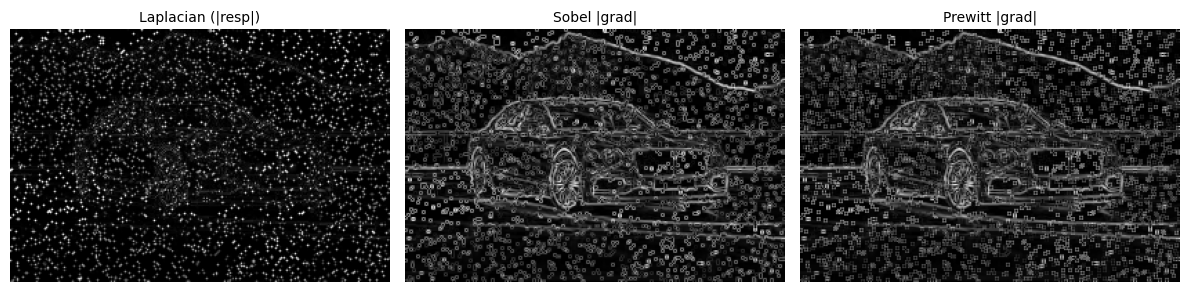

In [30]:
src = noise_img  # or: src = img
assert src.ndim == 2, f"Expected 2D grayscale, got {src.shape}"

def conv2d_reflect(img, kernel):
    k = kernel.shape[0]
    assert kernel.shape[0] == kernel.shape[1] and k % 2 == 1
    pad = k // 2
    imgf = img.astype(np.float32)
    kerf = kernel.astype(np.float32)
    padded = np.pad(imgf, pad, mode='reflect')
    out = np.empty_like(imgf)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            out[i, j] = np.sum(padded[i:i+k, j:j+k] * kerf)
    return out

def to_uint8_show(arr):
    a = np.abs(arr).astype(np.float32)  # abs for edge responses
    mn, mx = a.min(), a.max()
    if mx <= mn:  # avoid divide-by-zero
        return np.zeros_like(a, dtype=np.uint8)
    a = (a - mn) / (mx - mn)
    return (a * 255).astype(np.uint8)

# --- Laplacian (4-neighborhood) ---
lap_k = np.array([[ 0, -1,  0],
                  [-1,  4, -1],
                  [ 0, -1,  0]], dtype=np.float32)
lap_resp = conv2d_reflect(src, lap_k)
lap_show = to_uint8_show(lap_resp)

# --- Sobel (magnitude) ---
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)
sobel_y = np.array([[ 1,  2,  1],
                    [ 0,  0,  0],
                    [-1, -2, -1]], dtype=np.float32)
gx = conv2d_reflect(src, sobel_x)
gy = conv2d_reflect(src, sobel_y)
sobel_mag = np.hypot(gx, gy)
sobel_show = to_uint8_show(sobel_mag)

# --- Prewitt (magnitude) ---
prewitt_x = np.array([[-1, 0, 1],
                      [-1, 0, 1],
                      [-1, 0, 1]], dtype=np.float32)
prewitt_y = np.array([[ 1,  1,  1],
                      [ 0,  0,  0],
                      [-1, -1, -1]], dtype=np.float32)
px = conv2d_reflect(src, prewitt_x)
py = conv2d_reflect(src, prewitt_y)
prewitt_mag = np.hypot(px, py)
prewitt_show = to_uint8_show(prewitt_mag)

# --- visualize ---
titles = ["Laplacian (|resp|)", "Sobel |grad|", "Prewitt |grad|"]
imgs   = [lap_show, sobel_show, prewitt_show]

plt.figure(figsize=(12,4))
for i, (t, im) in enumerate(zip(titles, imgs), 1):
    plt.subplot(1,3,i)
    plt.imshow(im, cmap='gray')
    plt.title(t, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


Using Canny Edge Detector, LoG, and Max Pooling (OpenCV)

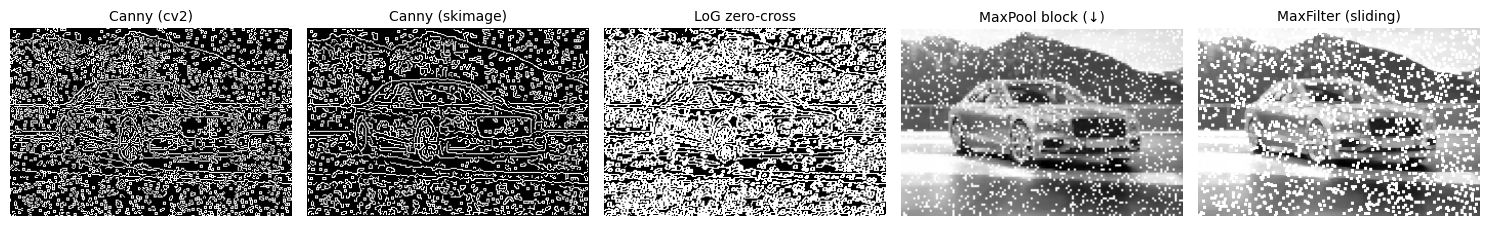

In [31]:
from skimage.feature import canny                  # Canny (skimage)
from skimage.measure import block_reduce           # Max pooling (downsampled block max)
from scipy.ndimage import gaussian_laplace         # LoG response

assert src.ndim == 2 and src.dtype == np.uint8, f"Expected 2D uint8, got {src.shape}, {src.dtype}"

# --- Canny (two popular options) ---
# 1) OpenCV:
canny_cv = cv2.Canny(src, threshold1=50, threshold2=150, L2gradient=True)

# 2) scikit-image (returns boolean); convert to uint8 for display:
canny_sk = canny(src.astype(np.float32) / 255.0, sigma=1.0, low_threshold=0.1, high_threshold=0.2)
canny_sk_u8 = (canny_sk.astype(np.uint8) * 255)

# --- LoG (Laplacian of Gaussian) ---
# Get LoG response with SciPy; then find zero-crossings by simple thresholding on the response sign changes.
log_resp = gaussian_laplace(src.astype(np.float32), sigma=1.2)

def zero_crossing_edges(log_arr, diff_thresh=0.01):
    """Binary edges from LoG response via zero-crossings with contrast threshold."""
    a = log_arr
    thr = diff_thresh * np.max(np.abs(a))  # relative threshold
    # Compare with right, down, diag neighbors
    zc = np.zeros_like(a, dtype=bool)
    zc[1:,  :] |= ((a[1:,  :] * a[:-1, :]) < 0) & (np.abs(a[1:,  :] - a[:-1, :]) > thr)
    zc[:, 1:] |= ((a[:, 1:] * a[:, :-1]) < 0) & (np.abs(a[:, 1:] - a[:, :-1]) > thr)
    zc[1:,1:] |= ((a[1:,1:] * a[:-1,:-1]) < 0) & (np.abs(a[1:,1:] - a[:-1,:-1]) > thr)
    zc[1:,:-1] |= ((a[1:,:-1] * a[:-1,1:]) < 0) & (np.abs(a[1:,:-1] - a[:-1,1:]) > thr)
    return (zc.astype(np.uint8) * 255)

log_edges = zero_crossing_edges(log_resp, diff_thresh=0.01)

# --- Max Pooling ---
# 1) Downsampled block max (true "pooling")
pool_k = 2  # try 2 or 4
h2 = (src.shape[0] // pool_k) * pool_k
w2 = (src.shape[1] // pool_k) * pool_k
src_crop = src[:h2, :w2]
maxpool_block = block_reduce(src_crop, block_size=(pool_k, pool_k), func=np.max)

# 2) Sliding-window max (no downsample) using dilation-like maximum filter (OpenCV)
#    NOTE: this is a different operation (maximum filter), not downsampling.
maxfilter_cv = cv2.dilate(src, kernel=np.ones((3,3), np.uint8), anchor=(-1,-1), iterations=1)

# --- visualize ---
titles = ["Canny (cv2)", "Canny (skimage)", "LoG zero-cross", "MaxPool block (↓)", "MaxFilter (sliding)"]
imgs   = [canny_cv, canny_sk_u8, log_edges, maxpool_block, maxfilter_cv]

plt.figure(figsize=(15,5))
for i, (t, im) in enumerate(zip(titles, imgs), 1):
    plt.subplot(1, len(imgs), i)
    plt.imshow(im, cmap='gray')
    plt.title(t, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

Scratch Implementation

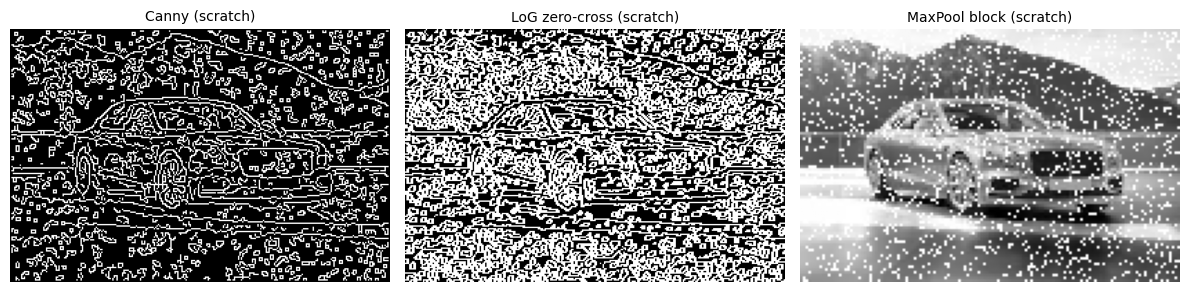

In [33]:
assert src.ndim == 2, f"Expected 2D grayscale, got {src.shape}"

# --- helpers: convolution + kernels ---
def conv2d_reflect(img, kernel):
    k = kernel.shape[0]
    assert kernel.shape[0] == kernel.shape[1] and k % 2 == 1
    pad = k // 2
    imgf = img.astype(np.float32)
    kerf = kernel.astype(np.float32)
    padded = np.pad(imgf, pad, mode='reflect')
    out = np.empty_like(imgf)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            out[i, j] = np.sum(padded[i:i+k, j:j+k] * kerf)
    return out

def gaussian_kernel(k=5, sigma=1.0):
    ax = np.arange(-(k//2), k//2 + 1, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    ker = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    ker /= ker.sum()
    return ker

# ===============================
# 1) CANNY (scratch, minimal)
# ===============================
def nonmax_suppression(mag, ang_deg):
    """Thin edges along gradient directions (0,45,90,135)."""
    H, W = mag.shape
    Z = np.zeros((H, W), dtype=np.float32)

    ang = ang_deg % 180.0
    # neighbor offsets per direction bin
    # 0°, 45°, 90°, 135°
    for i in range(1, H-1):
        for j in range(1, W-1):
            q = 0.0; r = 0.0
            a = ang[i, j]
            if (0 <= a < 22.5) or (157.5 <= a < 180):
                q, r = mag[i, j+1], mag[i, j-1]
            elif (22.5 <= a < 67.5):
                q, r = mag[i-1, j+1], mag[i+1, j-1]
            elif (67.5 <= a < 112.5):
                q, r = mag[i-1, j], mag[i+1, j]
            else:  # 112.5–157.5
                q, r = mag[i-1, j-1], mag[i+1, j+1]
            if mag[i, j] >= q and mag[i, j] >= r:
                Z[i, j] = mag[i, j]
    return Z

def canny_scratch(img, gauss_k=5, gauss_sigma=1.0, low_ratio=0.1, high_ratio=0.2):
    """Canny pipeline: blur -> Sobel -> NMS -> double threshold -> hysteresis."""
    # 1) Smooth
    gker = gaussian_kernel(gauss_k, gauss_sigma)
    sm = conv2d_reflect(img, gker)

    # 2) Gradients (Sobel)
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[ 1,  2,  1],
                        [ 0,  0,  0],
                        [-1, -2, -1]], dtype=np.float32)
    gx = conv2d_reflect(sm, sobel_x)
    gy = conv2d_reflect(sm, sobel_y)
    mag = np.hypot(gx, gy)
    ang = (np.degrees(np.arctan2(gy, gx)) + 180.0) % 180.0

    # 3) Non-maximum suppression
    nms = nonmax_suppression(mag, ang)

    # 4) Double threshold
    hi = nms.max() * high_ratio
    lo = nms.max() * low_ratio
    strong = (nms >= hi)
    weak   = (nms >= lo) & ~strong
    edges  = np.zeros_like(nms, dtype=np.uint8)

    # 5) Hysteresis (8-connectivity)
    H, W = nms.shape
    visited = np.zeros_like(strong, dtype=bool)
    idxs = list(zip(*np.nonzero(strong)))
    for (si, sj) in idxs:
        if visited[si, sj]:
            continue
        # DFS stack
        stack = [(si, sj)]
        visited[si, sj] = True
        edges[si, sj] = 255
        while stack:
            i, j = stack.pop()
            for di in (-1, 0, 1):
                for dj in (-1, 0, 1):
                    if di == 0 and dj == 0:
                        continue
                    ni, nj = i+di, j+dj
                    if 0 <= ni < H and 0 <= nj < W and not visited[ni, nj]:
                        if weak[ni, nj] or strong[ni, nj]:
                            visited[ni, nj] = True
                            edges[ni, nj] = 255
                            stack.append((ni, nj))
    return edges

canny_np = canny_scratch(src, gauss_k=5, gauss_sigma=1.0, low_ratio=0.1, high_ratio=0.2)

# ===============================
# 2) LoG (scratch): kernel + zero-crossing
# ===============================
def log_kernel(k=9, sigma=1.4):
    assert k % 2 == 1 and k >= 5
    ax = np.arange(-(k//2), k//2 + 1, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    r2 = xx**2 + yy**2
    # LoG formula (unnormalized, zero-sum enforced)
    ker = (r2 - 2*(sigma**2)) / (sigma**4) * np.exp(-r2/(2*sigma**2))
    ker -= ker.mean()  # force zero-sum
    return ker

log_resp_np = conv2d_reflect(src, log_kernel(9, 1.4))

def zero_crossing_edges_np(a, diff_thresh=0.01):
    thr = diff_thresh * np.max(np.abs(a))
    zc = np.zeros_like(a, dtype=bool)
    zc[1:,  :] |= ((a[1:,  :] * a[:-1, :]) < 0) & (np.abs(a[1:,  :] - a[:-1, :]) > thr)
    zc[:, 1:] |= ((a[:, 1:] * a[:, :-1]) < 0) & (np.abs(a[:, 1:] - a[:, :-1]) > thr)
    zc[1:,1:] |= ((a[1:,1:] * a[:-1,:-1]) < 0) & (np.abs(a[1:,1:] - a[:-1,:-1]) > thr)
    zc[1:,:-1] |= ((a[1:,:-1] * a[:-1,1:]) < 0) & (np.abs(a[1:,:-1] - a[:-1,1:]) > thr)
    return (zc.astype(np.uint8) * 255)

log_edges_np = zero_crossing_edges_np(log_resp_np, diff_thresh=0.01)

# ===============================
# 3) Max Pooling (scratch, block max with stride = k)
# ===============================
def max_pool2d(img, k=2):
    """Non-overlapping block max (downsamples). Crops right/bottom if not divisible."""
    H, W = img.shape
    H2 = (H // k) * k
    W2 = (W // k) * k
    if (H2 != H) or (W2 != W):
        img = img[:H2, :W2]
    # reshape trick: (H2, W2) -> (H2/k, k, W2/k, k) -> max over block axes
    out = img.reshape(H2//k, k, W2//k, k).max(axis=(1,3))
    return out

maxpool_np = max_pool2d(src, k=2)

# --- visualize ---
titles = ["Canny (scratch)", "LoG zero-cross (scratch)", "MaxPool block (scratch)"]
imgs   = [canny_np, log_edges_np, maxpool_np]

plt.figure(figsize=(12,4))
for i, (t, im) in enumerate(zip(titles, imgs), 1):
    plt.subplot(1,3,i)
    plt.imshow(im, cmap='gray')
    plt.title(t, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()